In [1]:
#import numpy as np
import geopandas as gpd
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import pylab as pl
%pylab inline






Populating the interactive namespace from numpy and matplotlib


In [2]:
county = ['Kings','Queens','New York','Bronx','Richmond']
city = ['New York']

ny_gdf=gpd.read_file('zillowGeo/ZillowNeighborhoods-NY.shp')

#filter by city
nyc_gdf=ny_gdf[ny_gdf.City.isin(county)]

#filter by county
#nyc_gdf=ny_gdf[ny_gdf.County.isin(county)]


# locate coordinate points to plot neighborhood names
nyc_gdf['coords'] = nyc_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
nyc_gdf['coords'] = [coords[0] for coords in nyc_gdf['coords']]

print('There are %d neighborhoods.' %(len(nyc_gdf)))

nyc_gdf.head()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


There are 278 neighborhoods.


,State,County,City,Name,RegionID,geometry,coords
2,NY,Queens,New York,Rego Park,6719,POLYGON ((-73.85629999999999 40.72303000000012...,"(-73.8621239628, 40.7222061023)"
5,NY,Queens,New York,Belle Harbor,10329,POLYGON ((-73.85618223699993 40.56810940300005...,"(-73.853686937, 40.575575506)"
10,NY,New York,New York,Roosevelt Island,20239,POLYGON ((-73.96143117599991 40.74851331600007...,"(-73.9504153048, 40.7610824865)"
13,NY,Queens,New York,Howard Beach,21970,POLYGON ((-73.85608525799972 40.65037135900031...,"(-73.8456830487, 40.6573991662)"
16,NY,Queens,New York,Breezy Point,37557,POLYGON ((-73.90962826099991 40.56552556300005...,"(-73.9258913812, 40.5533548185)"


In [3]:
def makeDict(IDcolumn, nameColumn):
    regions ={IDcolumn.iloc[i]:nameColumn.iloc[i] for i in range(len(IDcolumn))}
    return regions

NYregions = makeDict(nyc_gdf['RegionID'],nyc_gdf['Name'])

#not sure why this dropped 4 regions...
len(NYregions)

274

In [4]:
NYregions

{u'10007': u'Arverne',
 u'10329': u'Belle Harbor',
 u'10562': u'Broad Channel',
 u'10957': u'Corona',
 u'13356': u'Pomonok',
 u'16920': u'Bay Terrace',
 u'18071': u'Far Rockaway',
 u'18131': u'Flushing',
 u'193043': u'Arrochar',
 u'193182': u'Bath Beach',
 u'193189': u'Bay Ridge',
 u'193285': u'Bensonhurst',
 u'193292': u'Bergen Beach',
 u'193406': u'Borough Park',
 u'193476': u'Brighton Beach',
 u'193526': u'Brownsville',
 u'193555': u'Bulls Head',
 u'193587': u'Bushwick',
 u'193640': u'Canarsie',
 u'193821': u'Chinatown',
 u'193861': u'Clason Point',
 u'193879': u'Clifton',
 u'193974': u'Coney Island',
 u'194257': u'Dongan Hills',
 u'194318': u'Dyker Heights',
 u'194379': u'East Flatbush',
 u'194430': u'East New York',
 u'194474': u'East Tremont',
 u'194566': u'Elm Park',
 u'194737': u'Flatbush',
 u'194810': u'Fort Wadsworth',
 u'194861': u'Fresh Kills',
 u'195067': u'Graniteville',
 u'195069': u'Grant City',
 u'195087': u'Great Kills',
 u'195119': u'Greenridge',
 u'195133': u'Greenw

In [181]:
def plotNeighborhoods(thisDF, label):
    colors=['green','blue','red','yellow','magenta']
    pID = thisDF['RegionID']
    pName = []
    for rn in range(pID.shape[0]):
        #print(NYregions[pID.iloc[rn]])
        pName.append(NYregions[pID.iloc[rn]])
    #print(pName)
    thisPlot=nyc_gdf[nyc_gdf.Name.isin(pName)]
    notPlot=nyc_gdf[nyc_gdf.Name.isin(pName)==False]
    
    fig, ax = plt.subplots(1, figsize=(15,15))
    notPlot.plot(ax=ax, color='w',edgecolor='black', alpha=0.2)
    thisPlot.plot(ax=ax, color='g',edgecolor='black', alpha=0.2)
    
    #for labeling
    if label == True:
        for idx, row in thisPlot.iterrows():
            plt.annotate(s=row['Name'], xy=row['coords'], color='Black', horizontalalignment='center', size=10)
        
    plt.show()
    
def plotNeighborhoodClusters(thisDF, label, colorColumn, title):
    colors=['green','blue','red','yellow','magenta']
    pID = thisDF['RegionID']
    pName = []

    for rn in range(len(pID)):

        pName.append(NYregions[pID.iloc[rn]])
    thisPlot=nyc_gdf[nyc_gdf.Name.isin(pName)]
    
    #maybe not neccesary
    thisPlot.RegionID =thisPlot.RegionID.astype(str)

    thisPlot =thisPlot.merge(thisDF.loc[:,['RegionID',colorColumn]], how='inner', on='RegionID')

    notPlot=nyc_gdf[nyc_gdf.Name.isin(pName)==False]
    
    fig, ax = plt.subplots(1, figsize=(15,15))
    notPlot.plot(ax=ax, color='w',edgecolor='black', alpha=0.2)    

    for c in range(4): #for each cluster
        pl = thisPlot.loc[thisPlot[colorColumn]==c]
        pl.plot(ax=ax, edgecolor='black', color=colors[c])
    
    #for labeling
    if label == True:
        for idx, row in thisPlot.iterrows():
            plt.annotate(s=row['Name'], xy=row['coords'], color='Black', horizontalalignment='center', size=10)
    
    plt.title(title, fontsize=18)
    
    
    plt.savefig('%s.png' %(title), dpi=150)
    plt.show()

In [182]:
dfToMap=pd.read_csv('yelp_clusters.csv')

dfToMap.RegionID = dfToMap.RegionID.astype(str)

dfToMap.head()

,State,County,City,Name,RegionID,geometry,Wine Bar,Grocery Store,Fast Food,Laundromat,Hotel,clusters_allfeatures,clusters_wine,clusters_grocery,clusters_laundromat,clusters_hotel,clusters_fastfood
0,NY,Queens,New York,Howard Beach,21970,POLYGON ((-73.85608525799972 40.65037135900031...,1.0,2.500000,1.333333,1.000000,0.50,0,0,0,2,1,2
1,NY,Queens,New York,Fresh Meadows,4819,"POLYGON ((-73.7699123773972 40.74150740314482,...",2.0,0.615385,0.714286,0.750000,4.00,0,0,1,2,2,1
2,NY,Queens,New York,Maspeth,5837,"POLYGON ((-73.8881191182047 40.73555656190326,...",1.0,1.000000,0.250000,1.333333,0.25,0,0,1,2,1,1
3,NY,Queens,New York,Hollis,25160,POLYGON ((-73.75899062253634 40.72055073023243...,1.0,1.000000,1.500000,1.000000,1.00,0,0,1,2,1,2
4,NY,Queens,New York,South Ozone Park,27182,POLYGON ((-73.81073992748637 40.69114001943669...,1.0,4.000000,3.500000,4.000000,1.25,1,0,2,1,1,0


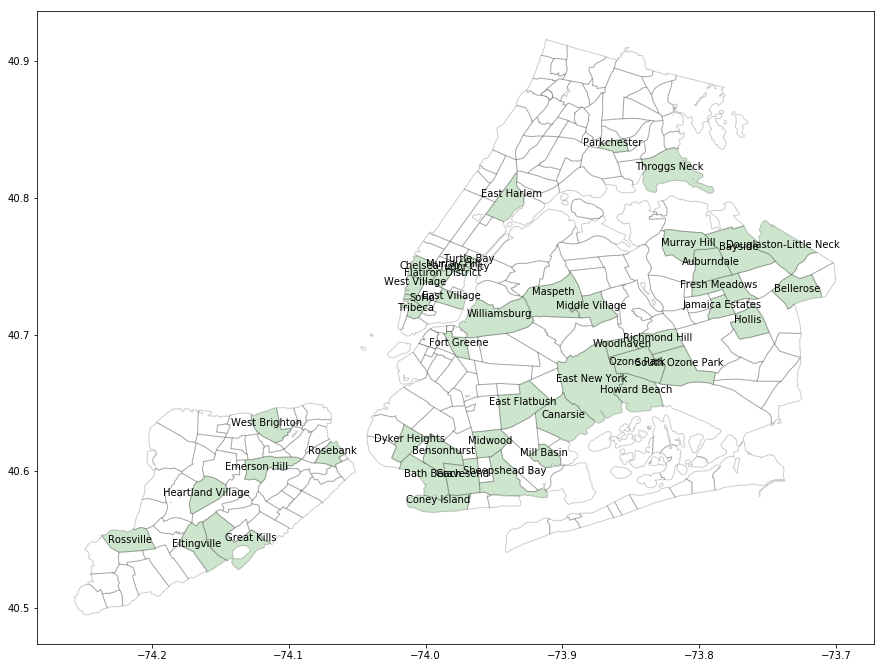

In [183]:
plotNeighborhoods(dfToMap, True) # a DF containing RegionID, boolean for labels

C:\ProgramData\Anaconda2\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


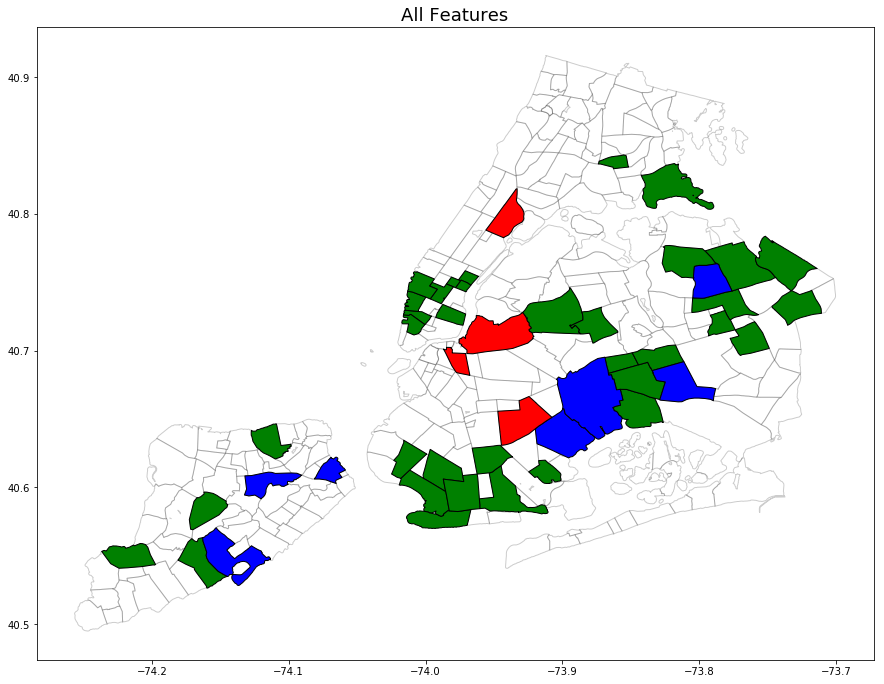

C:\ProgramData\Anaconda2\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


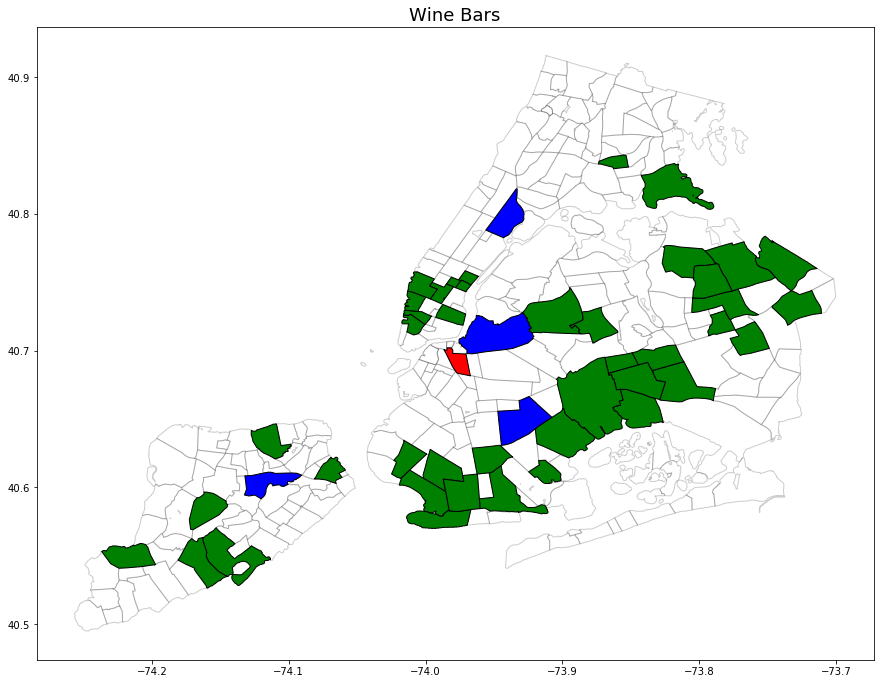

C:\ProgramData\Anaconda2\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


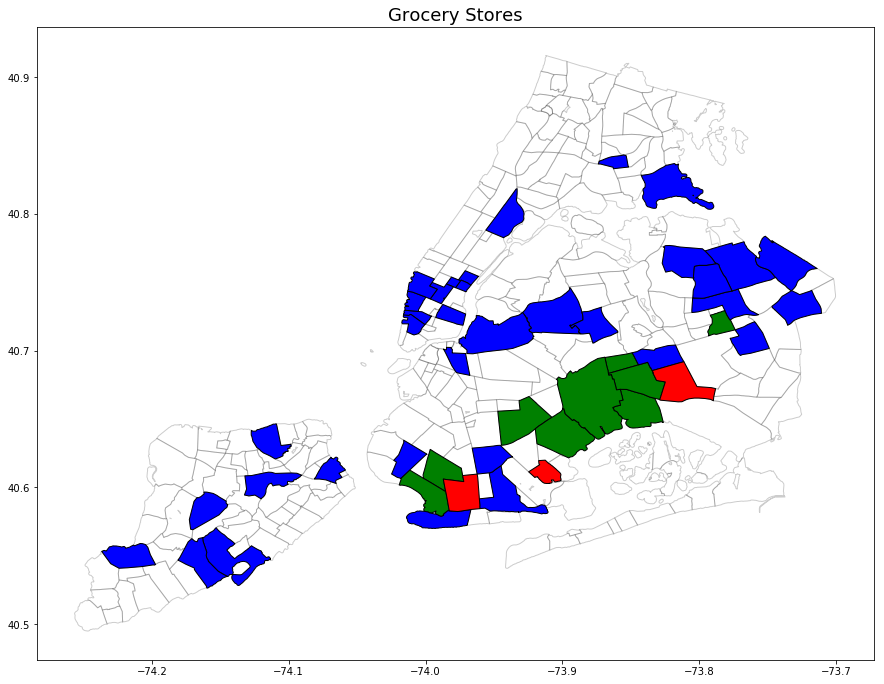

C:\ProgramData\Anaconda2\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


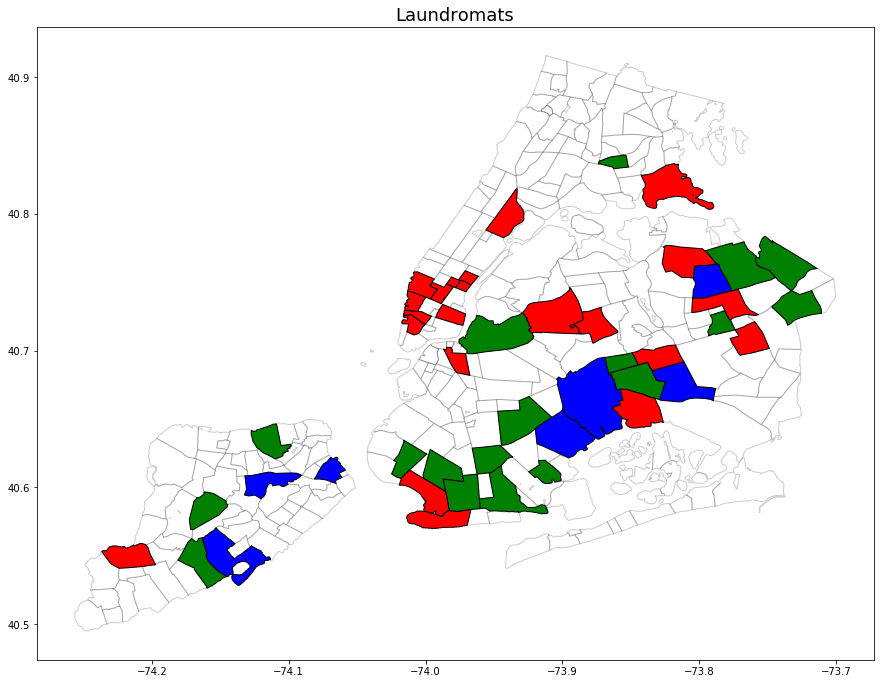

C:\ProgramData\Anaconda2\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


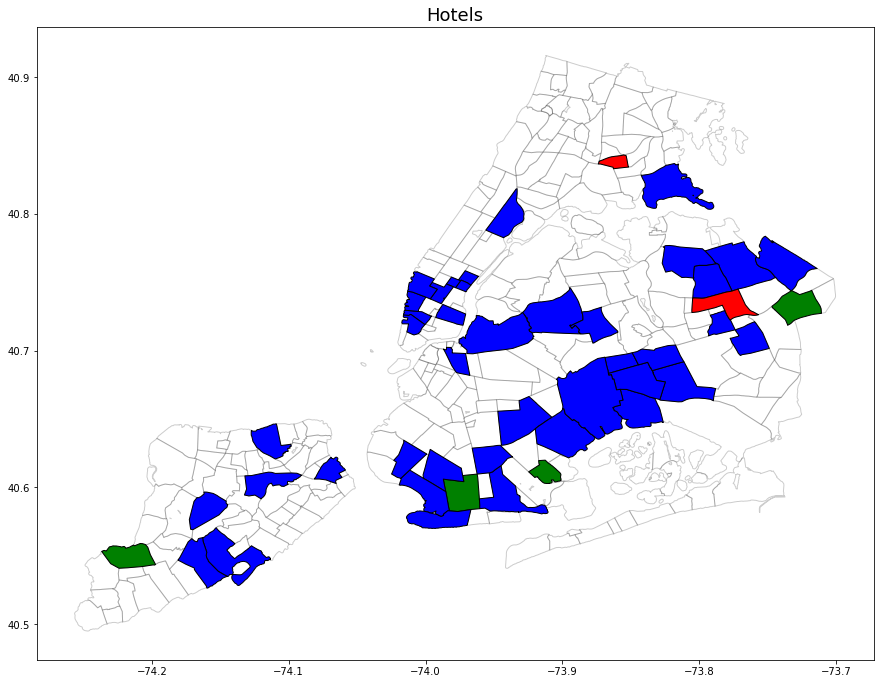

C:\ProgramData\Anaconda2\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


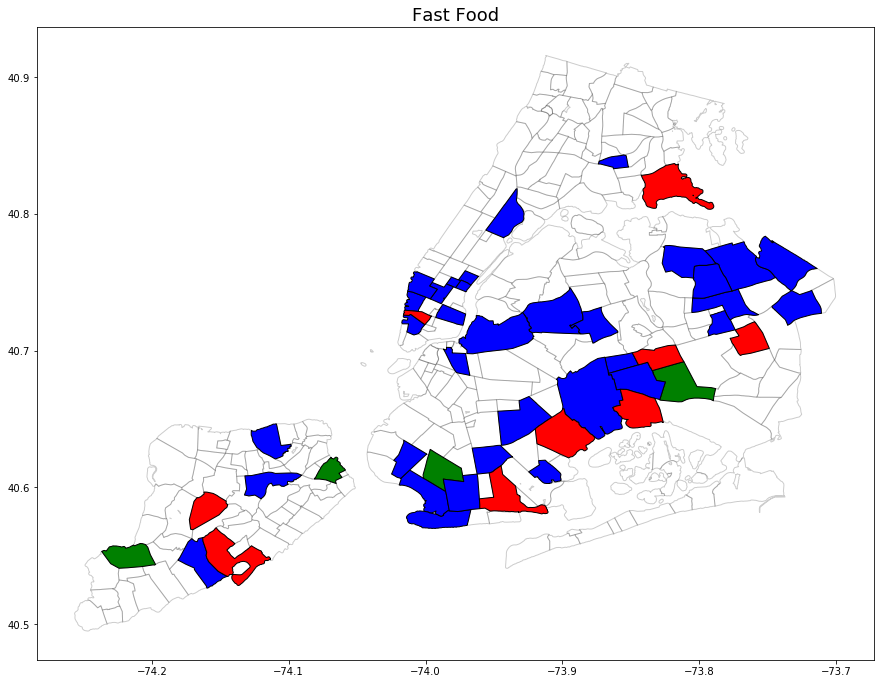

In [184]:
clusterNames=['clusters_allfeatures', 'clusters_wine','clusters_grocery','clusters_laundromat','clusters_hotel','clusters_fastfood']
clusterTitles=['All Features', 'Wine Bars','Grocery Stores','Laundromats','Hotels','Fast Food']

for m in range(len(clusterNames)):
    plotNeighborhoodClusters(dfToMap, False, clusterNames[m], clusterTitles[m]) # a DF containing RegionID, boolean for labels, collumn for color

In [158]:
#dfToMap.clusters_wine

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    1
23    0
24    1
25    0
26    0
27    0
28    0
29    0
30    0
31    2
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    1
43    0
44    0
45    0
46    0
Name: clusters_wine, dtype: int64